In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,make_scorer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib
import xgboost as xgb
from xgboost import plot_importance
import optuna

In [2]:
data = pd.read_csv('/content/train.csv')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
data.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [26]:
Avg_sales = data['sales'].mean()
print(f'Average Sales: {Avg_sales}')

Average Sales: 52.250286966046005


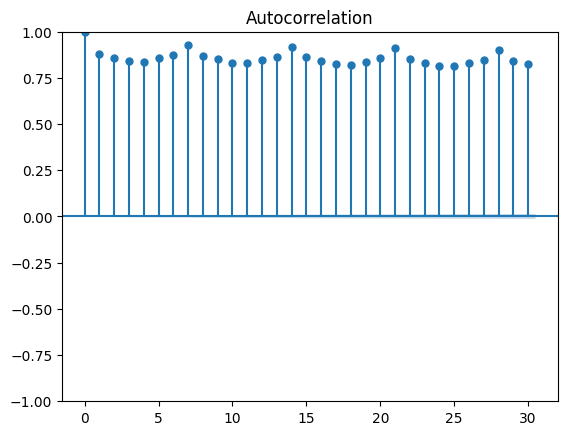

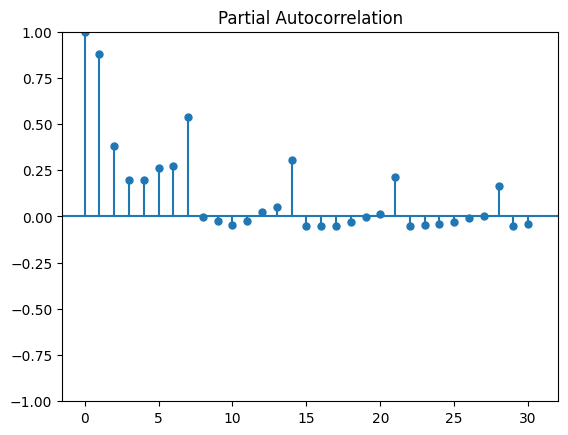

In [5]:
plot_acf(data['sales'], lags=30)
plt.show()

plot_pacf(data['sales'], lags=30)
plt.show()


In [6]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dow'] = data['date'].dt.dayofweek
data['is_weekend'] = data['dow'].isin([5,6]).astype(int)


In [7]:
data['lag_1'] = data.groupby(['store', 'item'])['sales'].shift(1)
data['lag_7'] = data.groupby(['store', 'item'])['sales'].shift(7)
data['lag_30'] = data.groupby(['store', 'item'])['sales'].shift(30)

data['rolling_mean_7'] = data.groupby(['store', 'item'])['sales'].shift(1).rolling(7).mean()
data['rolling_std_7'] = data.groupby(['store', 'item'])['sales'].shift(1).rolling(7).std()
data['sales_dif'] = data.groupby(['store', 'item'])['sales'].diff()

In [8]:
df_model = data.dropna()
df_model.head()

,date,store,item,sales,year,month,dow,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,sales_dif
30,2013-01-31,1,1,13,2013,1,3,0,9.0,8.0,13.0,10.285714,2.751623,4.0
31,2013-02-01,1,1,11,2013,2,4,0,13.0,14.0,11.0,11.000000,2.708013,-2.0
32,2013-02-02,1,1,21,2013,2,5,1,11.0,12.0,14.0,10.571429,2.370453,10.0
33,2013-02-03,1,1,15,2013,2,6,1,21.0,12.0,13.0,11.857143,4.634241,-6.0
34,2013-02-04,1,1,14,2013,2,0,0,15.0,11.0,10.0,12.285714,4.785892,-1.0


In [9]:
X = df_model.drop(columns=['sales','date'])
y = df_model['sales']

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [11]:
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

MAE: 0.36
MSE: 0.26
RMSE: 0.51
R2: 1.00


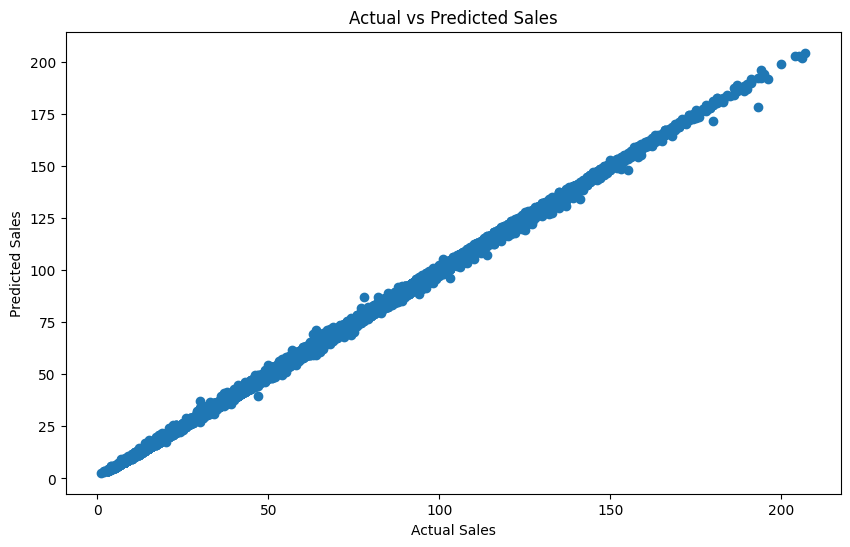

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

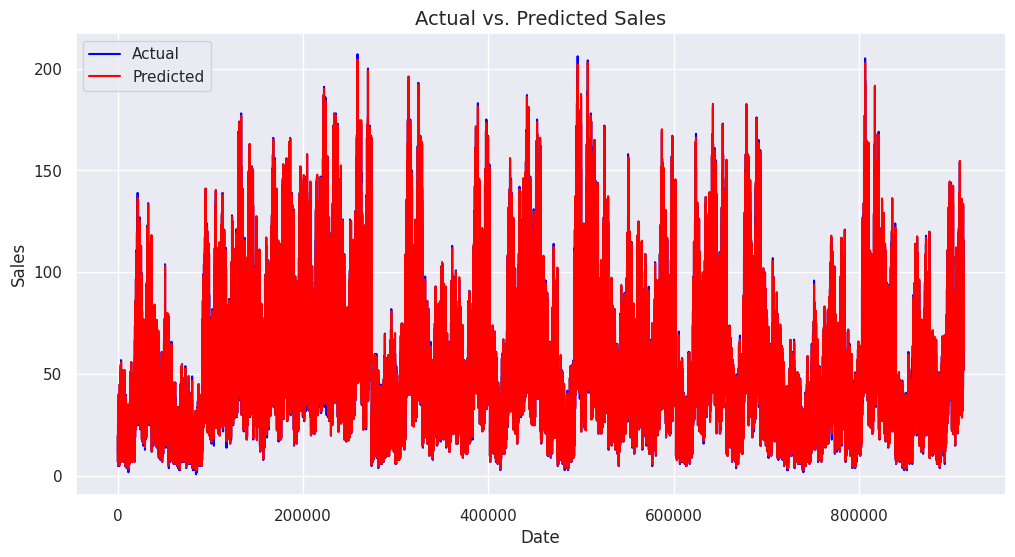

In [14]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))


sns.lineplot(x=X_test.index, y=y_test, label='Actual', color='blue')
sns.lineplot(x=X_test.index, y=y_pred, label='Predicted', color='red')

plt.title("Actual vs. Predicted Sales", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

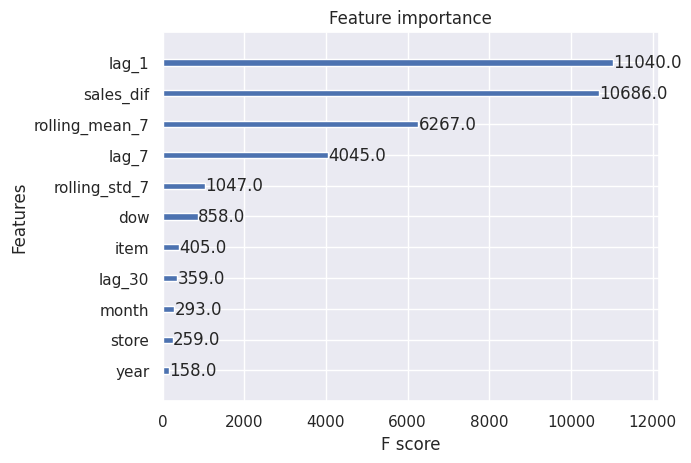

In [16]:
plot_importance(model)
plt.show()

In [19]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 8.3 MB/s eta 0:00:00


In [21]:
def objective(trials):
    params = {
        'n_estimators': trials.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trials.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trials.suggest_int('max_depth', 3, 10),
        'subsample': trials.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trials.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"RMSE: {trial.value:.4f}")
print("Best hyperparameters:")
print(trial.params)

[I 2025-07-19 06:37:31,821] A new study created in memory with name: no-name-147c19e7-2aa2-441a-a5c8-86fbee36d468
[I 2025-07-19 06:38:52,197] Trial 0 finished with value: 0.44635026040550885 and parameters: {'n_estimators': 619, 'learning_rate': 0.09441290729513394, 'max_depth': 10, 'subsample': 0.5755060548290891, 'colsample_bytree': 0.6352341858226822}. Best is trial 0 with value: 0.44635026040550885.
[I 2025-07-19 06:39:49,904] Trial 1 finished with value: 0.7702826689540291 and parameters: {'n_estimators': 392, 'learning_rate': 0.021316387471151315, 'max_depth': 10, 'subsample': 0.7848048174022135, 'colsample_bytree': 0.6818418025130122}. Best is trial 0 with value: 0.44635026040550885.
[I 2025-07-19 06:40:12,463] Trial 2 finished with value: 0.5945664614703149 and parameters: {'n_estimators': 350, 'learning_rate': 0.07674813651563238, 'max_depth': 6, 'subsample': 0.546816844691262, 'colsample_bytree': 0.8702276447274525}. Best is trial 0 with value: 0.44635026040550885.
[I 2025-07

Best trial:
RMSE: 0.2574
Best hyperparameters:
{'n_estimators': 987, 'learning_rate': 0.03516030085888851, 'max_depth': 9, 'subsample': 0.6296391085940853, 'colsample_bytree': 0.9238962013914507}


In [23]:
best_model = xgb.XGBRegressor(
    n_estimators=987,
    learning_rate= 0.03,
    max_depth=9,
    subsample=0.63,
    colsample_bytree=0.92,
    random_state=42
)

best_model.fit(X_train, y_train)
best_model_prediction = best_model.predict(X_test)

In [25]:
mae = mean_absolute_error(y_test, best_model_prediction)
mse = mean_squared_error(y_test,best_model_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,best_model_prediction)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

MAE: 0.16
MSE: 0.07
RMSE: 0.26
R2: 1.00


In [28]:
joblib.dump(best_model,"best_xgboost.pkl")

['best_xgboost.pkl']